# Команда 11: Борисова Анна, Кутузов Ярослав, Капланский Марк

## Подготовка баз данных

Начнём построение алгоритма с установки необходимых библиотек обработки данных и методов машинного обучения

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn import preprocessing
from sklearn.metrics import r2_score
from scipy import linalg
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import io
import pandas as pd
from google.colab import files
import seaborn as sns
import os

Загружаем сырые базы данных в среду обработки и сохраняем их содержимое в переменных df1, df2, df3, df4, df5 

In [247]:
#Если с GitHub автоматически не скачиваются базы данных, то используйте эту функцию, чтобы ввести их вручную

#uploaded = files.upload()

In [ ]:
df1 = pd.read_excel('Database_1.xlsx')
df2 = pd.read_excel('Database_2.xlsx')
df3 = pd.read_excel('Database_3.xlsx')
df4 = pd.read_excel('Database_4.xlsx')
df5 = pd.read_excel('Database_5.xlsx')

Поскольку базы данных содержат различные данные о свойствах наночастиц, мы выделили некоторые общие параметры, чтобы использовать их для построении модели МО. Свойства наночастиц для анализа:

1. Природа материала (Material type)
2. Линейный размер наночастиц (Hydro size (nm)/ Size_in_water)
3. Электроповерхностная характеристика (Surface charge (mV)/ Zeta_in_water)
4. Концентрация (Exposure dose (ug/mL)/ Concentration  μM/ dose)

5. Предсказываем биологическую активность: Viability (%)

Этот подход позволяет включить в рассмотрение почти все наночастицы из баз данных без внесения заметных информационных шумов. Однако построенная модель не будет зависеть от типа клеточной линии. Это придаёт предсказываемому параметру Viability некоторую абстрактность, что является ограничением подхода. Тем не менее, датасеты с большим числом сэмплом и не очень большим числом параметров являются более подходящими для гибких моделей. 


---



Первым этапом создадим общий DataFrame из рассматриваемых данных по наночастицам. Для этого сохраним в переменную Name_col список списков, состоящих из названий столбцов баз данных

In [ ]:
Name_col = [['Material type','Hydro size (nm)','Surface charge (mV)','Exposure dose (ug/mL)','Viability (%)'],
            ['Nanoparticle','Diameter (nm)', 'Zeta potential (mV)', 'Concentration μM', '% Cell viability'],
            ['Material','Size_in_Water (nm)','Zeta_in_Water (mV)','Concentration (ug/ml)', 'Cell_Viability (%)'],
            ['Material type','Hydro size (nm)','Surface charge (mV)','Exposure dose (ug/mL)','Viability (%)'],
            ['material', 'hydro_size', 'surf_charge','dose','viability']]

Переименуем столбцы каждого датасета единообразно, чтобы упростить их объединение. Полученные DataFrames сохраним в новые переменные df1_cols, df2_cols, df3_cols, df4_cols, df5_cols


In [ ]:
df1_cols = df1.loc[:,Name_col[0]]
df1_cols = df1_cols.rename(columns={'Hydro size (nm)': 'Diameter, nm',
                           'Surface charge (mV)': 'Surface charge, mV',
                           'Exposure dose (ug/mL)': 'Dose, ug/mL',
                           'Nanoparticle': 'Material type',
                           'Viability (%)': 'Viability, %'                                                   
                           })

df2_cols = df2.loc[:,Name_col[1]]
df2_cols = df2_cols.rename(columns={'Nanoparticle': 'Material type',
                           'Diameter (nm)': 'Diameter, nm',
                           'Zeta potential (mV)': 'Surface charge, mV', 
                           '% Cell viability': 'Viability, %'                                                   
                           })

df3_cols = df3.loc[:,Name_col[2]]
df3_cols = df3_cols.rename(columns={'Material': 'Material type',
                           'Size_in_Water (nm)': 'Diameter, nm',
                           'Zeta_in_Water (mV)': 'Surface charge, mV',
                           'Concentration (ug/ml)': 'Dose, ug/mL',
                           'Cell_Viability (%)': 'Viability, %'                                                   
                           })

df4_cols = df4.loc[:,Name_col[3]]
df4_cols = df4_cols.rename(columns={'Hydro size (nm)': 'Diameter, nm',
                           'Surface charge (mV)': 'Surface charge, mV',
                           'Exposure dose (ug/mL)': 'Dose, ug/mL',
                           'Nanoparticle': 'Material type',
                           'Viability (%)': 'Viability, %'                                                   
                           })

df5_cols = df5.loc[:,Name_col[4]]
df5_cols = df5_cols.rename(columns={'material': 'Material type',
                           'hydro_size': 'Diameter, nm', 
                           'surf_charge': 'Surface charge, mV',
                           'dose': 'Dose, ug/mL',
                           'viability': 'Viability, %'                                                  
                           })

---

В переменной df2_cols содержится концентрация частиц, выраженная в μM. Для построения модели необходимо привести всё к одним единицам измерения.
  
Полагая, что концентрация в DataFrames несёт информацию о содержании материала наночастиц, а не самих наночастиц, перейдём от μM к ug/ml следующим образом:

$C = M\cdot C/ 1000$

*C* - концентрация, выраженная в ug/ml;
**C** - концентрация, выраженная в μM;
*M* - молярная масса материала наночастицы
коэффициент 1 / 1000 возник при переводе единиц объёма "л" в "мл".

---

Исключим из датасета в переменной df2_cols наночастицы, для которых не найдено  молярной массы

In [ ]:
df2_cols = df2_cols[df2_cols['Material type'] != 'Liposomes']
df2_cols = df2_cols[df2_cols['Material type'] != 'SLN']
df2_cols = df2_cols[df2_cols['Material type'] != 'Dendrimer']
df2_cols = df2_cols[df2_cols['Material type'] != 'QDs']

Назовём наночастицы в df2_cols единообразно

In [ ]:
df2_cols = df2_cols.replace({'Material type':{'Copper Oxide':'CuO', "Zinc oxide":'ZnO','Iron oxide':'Fe3O4',
                                              'Hydroxyapatite':'HPA'}}) 

Обновим порядок следования индексов

In [ ]:
df2_cols = df2_cols.reset_index()
del df2_cols['index']
df2_cols

,Material type,"Diameter, nm","Surface charge, mV",Concentration μM,"Viability, %"
0,CeO2,20.3,NaN,0.002478,105.58918
1,CeO2,20.3,NaN,0.004956,103.02621
2,CeO2,20.3,NaN,0.009911,104.85748
3,CeO2,20.3,NaN,0.019823,100.09670
4,CeO2,20.3,NaN,0.039645,97.53237
...,...,...,...,...,...
2585,Chitosan,260.0,47.0,0.000180,95.50218
2586,Chitosan,260.0,47.0,0.000180,90.26201
2587,Chitosan,260.0,47.0,0.000180,89.56332
2588,Chitosan,260.0,47.0,0.000180,85.37118


Создадим промежуточные списки материалов наночастиц и соответствующих им молярных масс. В случае полимерных наночастиц брали молярную массу мономерного звена 

In [ ]:
df2_material = df2_cols['Material type'].unique()
df2_molmass=[172.115,78.96, 79.545, 95.611, 81.38, 231.533, 79.866, 47.867, 52.0,58.93,240.8,128.4112, 70.9374,208.98,95.95,195.084,502.31,143.09,40.3, 101.96, 60.08, 196.97, 107.87, 231.29, 148.11, 104.15, 12, 12, 1526.5]

Приведём все значения концентрации в столбце "Concentration μM" к концентрации в единицах ug/ml

In [ ]:
for i in range(len(df2_cols['Material type'])):
  for j in range(len(df2_material)):
    if df2_cols['Material type'][i] == df2_material[j]:
        df2_cols['Concentration μM'][i] =  (df2_cols['Concentration μM'][i] * df2_molmass[j])/1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df2_cols = df2_cols.rename(columns={'Concentration μM': 'Dose, ug/mL'})
df2_cols

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,CeO2,20.3,NaN,0.000426,105.58918
1,CeO2,20.3,NaN,0.000853,103.02621
2,CeO2,20.3,NaN,0.001706,104.85748
3,CeO2,20.3,NaN,0.003412,100.09670
4,CeO2,20.3,NaN,0.006824,97.53237
...,...,...,...,...,...
2585,Chitosan,260.0,47.0,0.000275,95.50218
2586,Chitosan,260.0,47.0,0.000275,90.26201
2587,Chitosan,260.0,47.0,0.000275,89.56332
2588,Chitosan,260.0,47.0,0.000275,85.37118


Объединим все базы данных в единую БД. Сохраним её в переменной df_Total

In [ ]:
df_Total = pd.concat([df1_cols,df2_cols, df3_cols,df4_cols,df5_cols])
df_Total

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,CuO,313.8,7.6,200.0,9.1000
1,ZnO,114.7,28.8,200.0,9.5000
2,ZnO,114.7,28.8,100.0,10.2000
3,ZnO,69.4,28.8,100.0,11.0000
4,Mn2O3,291.7,-46.1,200.0,11.3000
...,...,...,...,...,...
569,ZnO,236.0,-41.6,1.0,127.4363
570,ZnO,236.0,-41.6,10.0,116.3751
571,ZnO,236.0,-41.6,100.0,40.8796
572,ZnO,236.0,-41.6,0.1,86.8566


# Работа с объединённой базой данных

Посмотрим, какие наночастицы встречаются в объединённом датасете

In [ ]:
df_Total['Material type'].unique()

array(['CuO', 'ZnO', 'Mn2O3', 'CoO', 'CeO2', 'Fe2O3', 'Gd2O3', 'HfO2',
       'In2O3', 'La2O3', 'NiO', 'Sb2O3', 'SiO2', 'Al2O3', 'Se', 'CuS',
       'Fe3O4', 'TiO2', 'Ti', 'Cr', 'Co', 'Co3O4', 'CdO', 'MnO', 'Bi',
       'Mo', 'Pt', 'HPA', 'Cu2O', 'MgO', 'Au', 'Ag', 'Eudragit RL',
       'PLGA', 'Polystyrene', 'Carbon Nanotubes', 'Carbon NP', 'Chitosan',
       'QD', 'IronOxide', 'Dendrimer', 'Dendrmer', 'Alginate',
       'PTFE-PMMA', 'MWCNT', 'HAP', 'Ni', 'SLN', 'EudragitRL', 'Carbon',
       'ZrO2', 'C60', 'C70', 'SWCNT', 'Diamond', 'Graphite', 'IronOide',
       'Ay', 'Cu', 'Ce O2', 'Bi2O3', nan, "don't remember"], dtype=object)

Видно, что среди наночастиц есть эквивалентные, но алгоритм их распознаёт как разные из-за неверного написания. Также стоит заменить категорию "don't remember" на тип NaN. Переименуем единообразно и исправим ошибки в колонке "Material type"

In [ ]:
df_Total = df_Total.replace({'Material type':{'Ay':'Au', "don't remember":np.NaN,'IronOxide':'Fe2O3',
                                              'IronOide':'Fe3O4','Ce O2':'CeO2','Dendrmer':'Dendrimer',
                                              'Eudragit RL':'EudragitRL', 'NaN': np.NaN}})

Удалим повторяющиеся строки

In [ ]:
df_Total = df_Total.drop_duplicates()
df_Total

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,CuO,313.80,7.6,200.0,9.100000
1,ZnO,114.70,28.8,200.0,9.500000
2,ZnO,114.70,28.8,100.0,10.200000
3,ZnO,69.40,28.8,100.0,11.000000
4,Mn2O3,291.70,-46.1,200.0,11.300000
...,...,...,...,...,...
1067,ZnO,236.00,-41.6,1.0,84.457800
6,Al2O3,267.00,36.3,20.0,92.268000
21,CuO,239.00,NaN,1.0,96.649500
261,TiO2,707.00,-12.1,100.0,96.784502


Обновим порядок следования индексов

In [ ]:
df_Total = df_Total.reset_index()
df_Total.pop('index')
df_Total

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,CuO,313.80,7.6,200.0,9.100000
1,ZnO,114.70,28.8,200.0,9.500000
2,ZnO,114.70,28.8,100.0,10.200000
3,ZnO,69.40,28.8,100.0,11.000000
4,Mn2O3,291.70,-46.1,200.0,11.300000
...,...,...,...,...,...
7634,ZnO,236.00,-41.6,1.0,84.457800
7635,Al2O3,267.00,36.3,20.0,92.268000
7636,CuO,239.00,NaN,1.0,96.649500
7637,TiO2,707.00,-12.1,100.0,96.784502


## Уберём все NaN

Оценим количество NaN во всё датасете

In [ ]:
df_Total.isna().sum()

Material type            3
Diameter, nm          1759
Surface charge, mV    3107
Dose, ug/mL            213
Viability, %             0
dtype: int64

Поскольку нам не известно, какие наночастицы описаны среди трёх строк с NaN в колонке "Material type", то удалим эти строки целиком. Удаление всего трёх объектов не повлияет сильно на общую статистику

In [ ]:
df_Total = df_Total[df_Total['Material type'].notna()]
df_Total.isna().sum()


Material type            0
Diameter, nm          1759
Surface charge, mV    3106
Dose, ug/mL            213
Viability, %             0
dtype: int64

Очистку оставшихся колонок от NaN проведём методом интерполяции. По сути, это альтернативу методу k-ближайших. В некоторых случаях мы присваивали nan наиближайшее не NaN значение, в других -- интерполирование линейной\квадратичной функцией. Выбор метода интерполяции зависит от типа данных: если данные условно дискретные, например тип материала и характеристики материала, но мы прибегали к вариации метода k-ближайших. Если переменная типа continous, то мы применяли квадратичную интерполяцию (концентрации например). Чтобы не стоить отдельные модели, мы применяли различные варианты сортировок.

Наночастицы одного материала и примерно одинаковых физических характеристик и концентрации должны давать примерно одинаковое значение Viability. 

Следовательно, проведём интерполяцию по соседним значениям Diameter и Surface charge, предварительно отсортировав датасет по возрастанию Viability и по Material type. Перед этим уберём не имеющие физического смысла значения Viability.

In [ ]:
df_Total = df_Total.loc[df_Total["Viability, %"] >= 0.].loc[df_Total["Viability, %"] <= 200.]
df_Total.sort_values(['Viability, %'])

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
2450,Ag,28.41,-33.33,3.555514e-04,0.0000
1888,Cu2O,88.50,NaN,3.510280e-05,0.0000
6537,Ag,28.41,-33.33,2.000000e+02,0.0000
1928,Cu2O,88.50,NaN,3.699833e-04,0.0000
6538,Ag,28.41,-33.33,2.500000e+02,0.0000
...,...,...,...,...,...
3414,Dendrimer,NaN,NaN,9.239100e+00,173.9500
841,Fe3O4,145.80,17.7,5.651580e-07,179.0393
3415,Dendrimer,NaN,NaN,1.847820e+01,180.6700
4769,Fe2O3,NaN,NaN,1.000000e+01,184.8200


*Мы* ограничили Viability сверху числом 200, учтя, что в относительно благоприятной среде клетки способны делиться. Таким образом, величина Viability > 100 % оказывается физически обоснованной. 

In [ ]:
df_Total = df_Total.sort_values(['Material type', 'Viability, %'], ascending=[True, True])
df_Total

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
2399,Ag,100.00,NaN,0.000088,0.000
2446,Ag,28.41,-33.33,0.000213,0.000
2450,Ag,28.41,-33.33,0.000356,0.000
6537,Ag,28.41,-33.33,200.000000,0.000
6538,Ag,28.41,-33.33,250.000000,0.000
...,...,...,...,...,...
5991,ZrO2,39.00,11.8,100.000000,77.126
5990,ZrO2,39.00,11.8,50.000000,81.085
5989,ZrO2,39.00,11.8,25.000000,88.710
5976,ZrO2,10.00,-45.5,50.000000,93.610


Очистим колонку Diameter от NaN применяя интерполяцию по методу "nearest" (а-ля k-ближайшее)

In [ ]:
df_Total['Diameter, nm'] = df_Total.sort_values(['Material type', 'Viability, %'], ascending=[True, True])['Diameter, nm'].interpolate(method='nearest')
df_Total.isna().sum()

Material type            0
Diameter, nm             0
Surface charge, mV    3087
Dose, ug/mL            213
Viability, %             0
dtype: int64

Очистим колонку Surface charge от NaN. Для этого понадобиться исправить строковое значение 15О на численное 150. Также через nearest.

In [ ]:
df_Total['Surface charge, mV'].replace('15O', 150, inplace=True)
df_Total['Surface charge, mV'].astype(float)
df_Total['Surface charge, mV'] = df_Total['Surface charge, mV'].interpolate(method='nearest')
df_Total['Surface charge, mV'][2399] = -33.33
df_Total.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Material type           0
Diameter, nm            0
Surface charge, mV      0
Dose, ug/mL           213
Viability, %            0
dtype: int64

Очистим колонку Dose от NaN. Интерполяция здесь идет полиномом второго порядка. Полагаем, что можно было и первого, но интерполяция полиномом второго порядка "плавнее". Мы заранее отсортировали данные так, чтобы не было большого разброса концетраций (в порядке возрастания). 

In [ ]:
df_Total['Dose, ug/mL'] = df_Total['Dose, ug/mL'].interpolate(method='polynomial', order=2)
df_Total.isna().sum()

Material type         0
Diameter, nm          0
Surface charge, mV    0
Dose, ug/mL           0
Viability, %          0
dtype: int64

Обновим порядок следования индексов

In [ ]:
df_Total = df_Total.reset_index()
df_Total.pop('index')
df_Total

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,Ag,100.00,-33.33,0.000088,0.000
1,Ag,28.41,-33.33,0.000213,0.000
2,Ag,28.41,-33.33,0.000356,0.000
3,Ag,28.41,-33.33,200.000000,0.000
4,Ag,28.41,-33.33,250.000000,0.000
...,...,...,...,...,...
7596,ZrO2,39.00,11.80,100.000000,77.126
7597,ZrO2,39.00,11.80,50.000000,81.085
7598,ZrO2,39.00,11.80,25.000000,88.710
7599,ZrO2,10.00,-45.50,50.000000,93.610


In [ ]:
df_Total.to_csv(r'Total_data_set.txt', header=True, index=None, sep='\t', mode='a')

# Избавляемся от ошибок и выбросов
Построим boxplot всех параметров для некоторых наночастиц  

Surface charge

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,Ag,100.00,-33.33,0.000088,0.000
1,Ag,28.41,-33.33,0.000213,0.000
2,Ag,28.41,-33.33,0.000356,0.000
3,Ag,28.41,-33.33,200.000000,0.000
4,Ag,28.41,-33.33,250.000000,0.000
...,...,...,...,...,...
7596,ZrO2,39.00,11.80,100.000000,77.126
7597,ZrO2,39.00,11.80,50.000000,81.085
7598,ZrO2,39.00,11.80,25.000000,88.710
7599,ZrO2,10.00,-45.50,50.000000,93.610


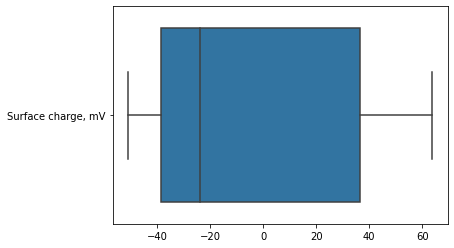

In [ ]:
LIMIT = 1000
name = 'Polystyrene'
df = df_Total
for col in df_Total.groupby(['Material type']).get_group(name).iloc[:,[2]]:  
       Q1 = df_Total[col].quantile(0.25)
       Q3 = df_Total[col].quantile(0.75)
       IQR = Q3 - Q1    #IQR is interquartile range. 
       filter = (df_Total[col] >= Q1 - LIMIT * IQR) & (df_Total[col] <= Q3 + LIMIT *IQR)     
       df.loc[~filter,2] = np.nan
sns.boxplot(data=df.groupby(['Material type']).get_group(name).iloc[:,[2]], orient="h")
df_Total.pop(2)
df_Total

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54],
 <a list of 55 Text major ticklabel objects>)

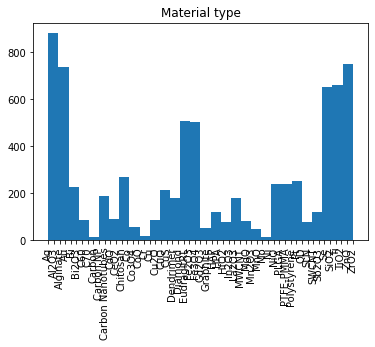

In [ ]:
name = 'Material type'

plt.hist(df_Total[name], bins=30)
plt.title(name)
plt.xticks(rotation = 90)

(-50.0, 1000.0)

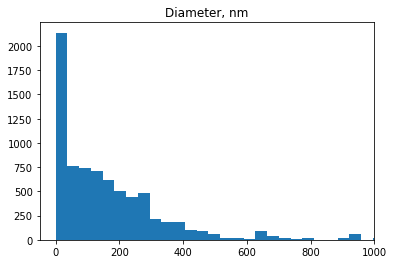

In [ ]:
name = 'Diameter, nm'

plt.hist(df_Total[name], bins=50)
plt.title(name)
plt.xlim([-50 , 1000])

(-200.0, 200.0)

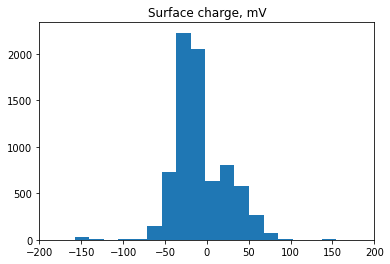

In [ ]:
name = 'Surface charge, mV'

plt.hist(df_Total[name], bins=30)
plt.title(name)
plt.xlim([-200 , 200])

(-50.0, 1250.0)

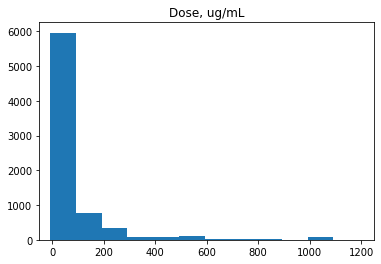

In [ ]:
name = 'Dose, ug/mL'

plt.hist(df_Total[name], bins=1000)
plt.title(name)
plt.xlim([-50 , 1250])

Text(0.5, 1.0, 'Viability, %')

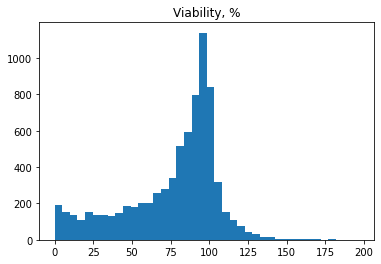

In [ ]:
name = 'Viability, %'

plt.hist(df_Total[name], bins=40)
plt.title(name)

##Построим pairplot параметров для всех наночастиц

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


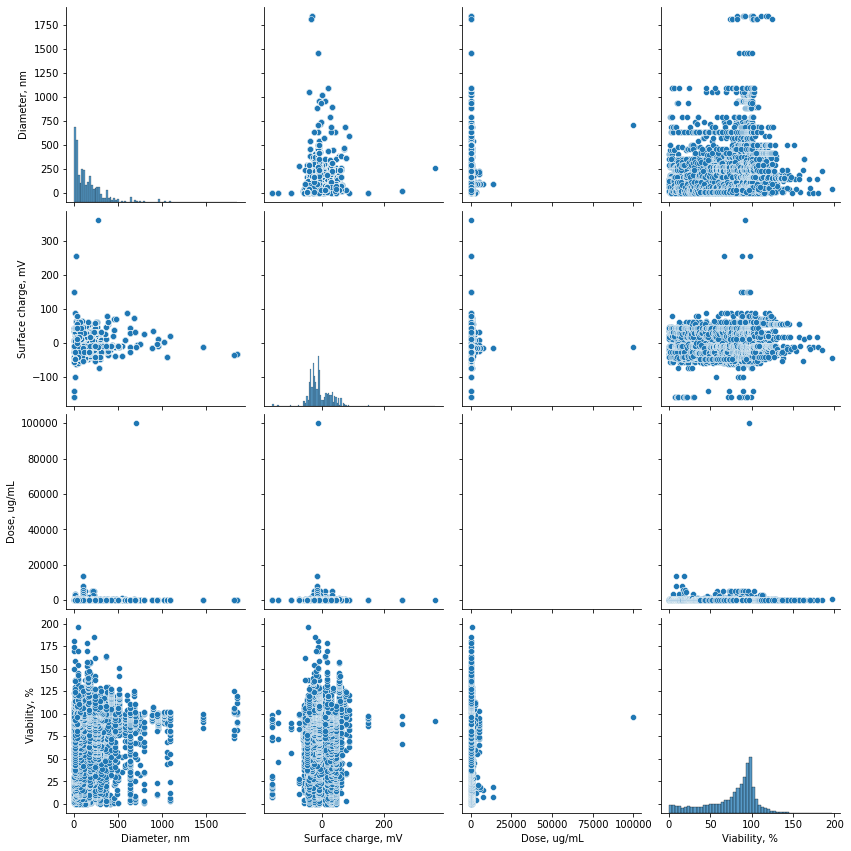

In [ ]:
sns.pairplot(df_Total, size=3)

## Корреляционная матрица

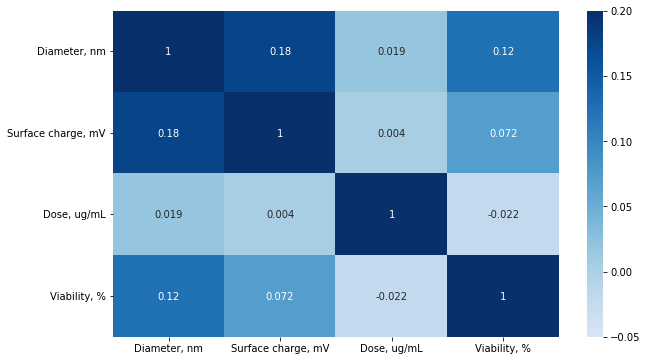

In [ ]:
data_corr=df_Total.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr, annot = True, vmin=-0.05, vmax=0.2, center= 0.05,cmap="Blues")

# Подбор модели МО

# 0. Импорт данных, библиотек

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm
import io
from google.colab import files

In [ ]:
#популярные модели
#Linear Regression
from sklearn.linear_model import LinearRegression

#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge

#Bayesian Ridge Regression
from sklearn.linear_model import BayesianRidge

#Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor

#Support Vector Machine
from sklearn.svm import SVR

#Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor

#LGBM Regressor
from lightgbm import LGBMRegressor

#Elastic Net Regression
from sklearn.linear_model import ElasticNet

#XGBoost Regressor
from xgboost.sklearn import XGBRegressor

#CatBoost Regressor
!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
merged_df = df_Total
merged_df

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,Ag,100.00,-33.33,0.000088,0.000
1,Ag,28.41,-33.33,0.000213,0.000
2,Ag,28.41,-33.33,0.000356,0.000
3,Ag,28.41,-33.33,200.000000,0.000
4,Ag,28.41,-33.33,250.000000,0.000
...,...,...,...,...,...
7596,ZrO2,39.00,11.80,100.000000,77.126
7597,ZrO2,39.00,11.80,50.000000,81.085
7598,ZrO2,39.00,11.80,25.000000,88.710
7599,ZrO2,10.00,-45.50,50.000000,93.610


# 0.1 Нормализация и стандартизация данных

#1. Найти выбросы и ошибки
IQR -- Обнаружение и удаление выбросов с помощью boxplots

Разделим датасет на категориальные переменные и численные

In [ ]:
numeric_col = ['Diameter, nm','Surface charge, mV',	'Dose, ug/mL' ,	'Viability, %' ]
categorical_col = merged_df['Material type']

Нормализуем численные данные

In [ ]:
merged_df = pd.DataFrame( preprocessing.normalize(merged_df.iloc[:,1:]), columns = numeric_col)

Построим boxplot для всех наночастиц по всем параметрам

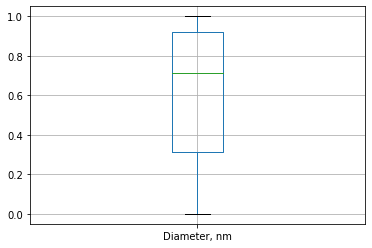

In [ ]:
merged_df.boxplot('Diameter, nm')

Мы полагаем, что физического смысла в поиске выбросов в поверхностном заряде нет, так как датасет мы рассматриваем из различных частиц. Выбросы имеет смысл рассматривать в рамках каждого вида material, но из-за ограничения во времени, мы этого не сделали (🤡). Но предполагаем, что так было бы правильнее.

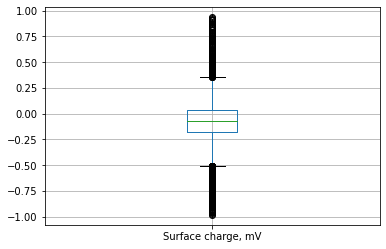

In [ ]:
merged_df.boxplot('Surface charge, mV')

То же самое касается и концетрации в целом. От того, что мы берем больший диапазон концентраций, мы естественно увеличиваем разброс данных.

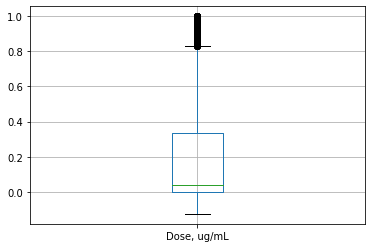

In [ ]:
merged_df.boxplot('Dose, ug/mL')

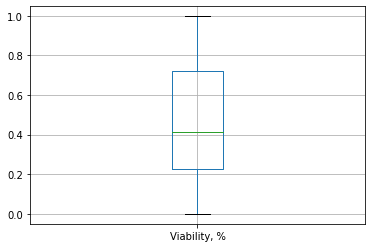

In [ ]:
merged_df.boxplot('Viability, %')

Алгоритм устранения выбросов для Surface charge и Viability представлены ниже, однако заметного изменения в датасет эта процедура не внесла

In [ ]:
for x in ['Surface charge, mV']:
    q75,q25 = np.percentile(merged_df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    merged_df.loc[merged_df[x] < min,x] = np.nan
    merged_df.loc[merged_df[x] > max,x] = np.nan

In [ ]:
for y in ['Viability, %']:
    q75,q25 = np.percentile(merged_df.loc[:,y],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    merged_df.loc[merged_df[y] < min,y] = np.nan
    merged_df.loc[merged_df[y] > max,y] = np.nan

In [ ]:
merged_df.isnull().sum()

Diameter, nm          0
Surface charge, mV    0
Dose, ug/mL           0
Viability, %          0
dtype: int64

Корреляционная матрица на нормированных данных

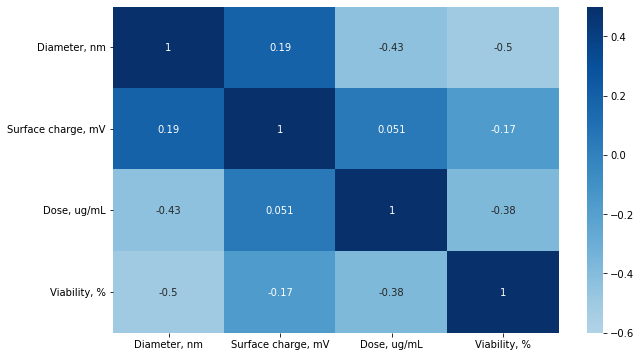

In [ ]:
data_corr=merged_df[numeric_col].corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr, annot = True, vmin=-0.6, vmax=0.5, center= -0.3, cmap="Blues")

# 2. Новый дескриптор

* Диаметр наночастицы и её поверхностный заряд -- это взаимосвязанные параметры. Коль так, можно взять их отношение. 

In [ ]:
merged_df = pd.concat((categorical_col,merged_df) , axis = 1)
merged_df

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
0,Ag,0.948693,-0.316199,8.353441e-07,0.000000
1,Ag,0.648702,NaN,4.871104e-06,0.000000
2,Ag,0.648702,NaN,8.118506e-06,0.000000
3,Ag,0.138762,-0.162793,9.768539e-01,0.000000
4,Ag,0.111935,-0.131320,9.850002e-01,0.000000
...,...,...,...,...,...
7596,ZrO2,0.293901,0.088924,7.535930e-01,0.581216
7597,ZrO2,0.376412,0.113889,4.825792e-01,0.782599
7598,ZrO2,0.387018,0.117098,2.480884e-01,0.880317
7599,ZrO2,0.086280,-0.392576,4.314020e-01,0.807671


In [ ]:
merged_df = merged_df.sort_values(['Material type', 'Surface charge, mV'], ascending=[True, True])

In [ ]:
merged_df['Surface charge, mV'] = merged_df['Surface charge, mV'].interpolate()

In [ ]:
merged_df.isna().sum()

Material type         0
Diameter, nm          0
Surface charge, mV    0
Dose, ug/mL           0
Viability, %          0
dtype: int64

In [ ]:
datatypes = merged_df['Material type'].unique()
len(datatypes)

Превращаем каждое категориальное значение в Material type в числовое

In [230]:
merged_df['Material type'] = merged_df['Material type'].astype('category').cat.codes
merged_df

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %"
316,0,0.430821,-0.505429,3.032880e-01,0.683338
109,0,0.793334,-0.503462,2.937953e-01,0.175586
330,0,0.429028,-0.503327,4.295432e-06,0.750065
643,0,0.070133,-0.498821,4.383313e-02,0.862750
166,0,0.730665,-0.497566,6.031943e-07,0.467500
...,...,...,...,...,...
7594,54,0.179826,0.054409,9.221861e-01,0.338046
7596,54,0.293901,0.088924,7.535930e-01,0.581216
7600,54,0.368348,0.111449,1.180603e-01,0.915402
7597,54,0.376412,0.113889,4.825792e-01,0.782599


Построение новых дескрипторов

In [237]:
SbC = pd.DataFrame( (merged_df['Surface charge, mV'] / merged_df['Diameter, nm']), columns = ['SurfCharge_by_Diameter'])

In [238]:
SbC

,SurfCharge_by_Diameter
316,-1.173178
109,-0.634615
330,-1.173178
643,-7.112500
166,-0.680977
...,...
7594,0.302564
7596,0.302564
7600,0.302564
7597,0.302564


Включение новых дескрипторов в общий датасет и нормализация данных

---



In [244]:
SbC = pd.DataFrame((preprocessing.normalize(SbC)), columns = ['SurfCharge_by_Diameter'])

In [246]:
proccessed_df = pd.concat((merged_df, SbC), axis = 1)
proccessed_df

,Material type,"Diameter, nm","Surface charge, mV","Dose, ug/mL","Viability, %",SurfCharge_by_Diameter
0,0,0.948693,-0.316199,8.353441e-07,0.000000,-1.0
1,0,0.648702,0.327988,4.871104e-06,0.000000,-1.0
2,0,0.648702,0.324779,8.118506e-06,0.000000,-1.0
3,0,0.138762,-0.162793,9.768539e-01,0.000000,-1.0
4,0,0.111935,-0.131320,9.850002e-01,0.000000,-1.0
...,...,...,...,...,...,...
7596,54,0.293901,0.088924,7.535930e-01,0.581216,1.0
7597,54,0.376412,0.113889,4.825792e-01,0.782599,1.0
7598,54,0.387018,0.117098,2.480884e-01,0.880317,1.0
7599,54,0.086280,-0.392576,4.314020e-01,0.807671,1.0


#Подготовка наборов для обучения и тестирования модели 

In [ ]:
Y = pd.DataFrame(proccessed_df.pop('Viability, %'))
X = proccessed_df

Разбиение датасета на тренировочную и тестовую выборку

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, random_state=0, train_size = .80)

# Модели обучения МО
##Линейная регрессия

Обучение модели

In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


regressor = LinearRegression()
model = regressor.fit(X_train, y_train)

Вычисление коэффициента детерминации, наклона и подъёма прямой

In [ ]:
r_sq = model.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
y_pred = model.predict(X_test)

coefficient of determination: 0.7051414286886822
intercept: [1.03344178]
slope: [[-2.17004796e-04 -7.09021437e-01 -2.43066280e-01 -6.63803095e-01
   4.39425963e-02  1.06006989e-02]]


Кросс-валидация модели

In [ ]:
# Perform 6-fold cross validation
scores = cross_val_score(model, X, Y, cv=10)
print("Cross-validated scores:", scores)

predictions = cross_val_predict(model, X, Y, cv=10)

Cross-validated scores: [0.59607827 0.66611933 0.77235965 0.74819645 0.65773271 0.72310342
 0.69399661 0.5023581  0.75052955 0.54745855]


Подсчёт метрик точности модели

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = r2_score(y_test, y_pred)

print(regressor.intercept_)
print(regressor.coef_)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Accuracy: {r2_score:.2f}')

[1.03344178]
[[-2.17004796e-04 -7.09021437e-01 -2.43066280e-01 -6.63803095e-01
   4.39425963e-02  1.06006989e-02]]
Mean absolute error: 0.13
Mean squared error: 0.03
Root mean squared error: 0.16
Accuracy: 0.71


Визуализация качества модели графиком "Введено - найдено"

Text(0.5, 1.0, 'LinearRegression "Introduced - Found"')

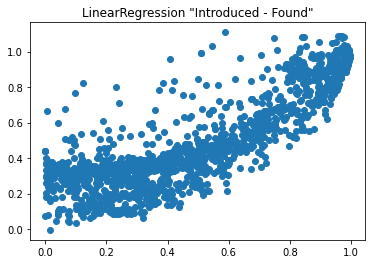

In [ ]:
plt.scatter(y_test,y_pred)
plt.title('LinearRegression "Introduced - Found"')

##Случайный лес

Обучение модели

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


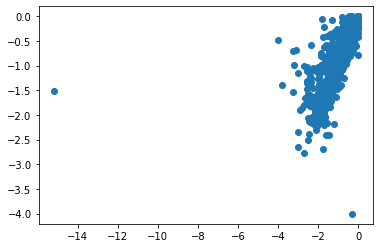

In [ ]:
regr = RandomForestRegressor(random_state=0, n_estimators=50, oob_score = True)
regr.fit(X_train, y_train)

Предсказание

In [ ]:
predicted = regr.predict(X_test)

array([0.14893044, 0.32736756, 0.58150269, ..., 0.80127706, 0.76056364,
       0.34837484])

Вычисление коэффициента детерминации

In [ ]:
r_sq = regr.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")
y_pred = regr.predict(X_test)

coefficient of determination: 0.9626358844279805


Кросс-валидация

In [ ]:
# Perform 6-fold cross validation
scores = cross_val_score(regr, X, np.ravel(Y), cv=10)
print("Cross-validated scores:", scores)

predictions = cross_val_predict(regr, X, np.ravel(Y), cv=10)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. Thi

Cross-validated scores: [0.694411   0.83139383 0.93972757 0.80829241 0.90436774 0.96030355
 0.8562571  0.77101683 0.94565314 0.82394976]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. Thi

Подсчёт метрик точности модели

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_sq = regr.score(X_test, y_test)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Accuracy: {r_sq:.2f}')

Mean absolute error: 0.02
Mean squared error: 0.00
Root mean squared error: 0.06
Accuracy: 0.96


Визуализация качества модели графиком "Введено - найдено"

Text(0.5, 1.0, 'RandomForestRegressor "Introduced - Found"')

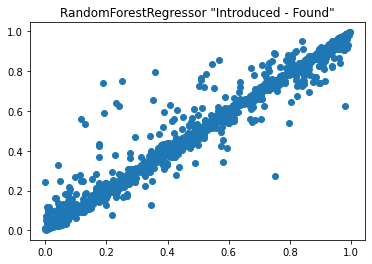

In [ ]:
plt.scatter(y_test,y_pred)
plt.title('RandomForestRegressor "Introduced - Found"')

##Gaussian

Обучение модели

In [ ]:
from sklearn import linear_model
clf = BayesianRidge()
clf.fit(X_train, np.ravel(y_train))

BayesianRidge()

Предсказание

In [ ]:
y_pred = clf.predict(X_test)

Кросс-валидация

In [ ]:
scores = cross_val_score(clf, X, np.ravel(Y), cv=10)
print("Cross-validated scores:", scores)

predictions = cross_val_predict(clf, X, np.ravel(Y), cv=10)

Cross-validated scores: [0.59603542 0.66621562 0.77232654 0.74823557 0.65774863 0.72311576
 0.69400646 0.50242257 0.75044947 0.54741236]


Подсчёт метрик точности модели

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = clf.score(X_test, np.ravel(y_test))

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Accuracy: {r2:.2f}')

Mean absolute error: 0.13
Mean squared error: 0.03
Root mean squared error: 0.16
Accuracy: 0.71


Визуализация качества модели графиком "Введено - найдено"

Text(0.5, 1.0, 'BayesianRidge "Introduced - Found"')

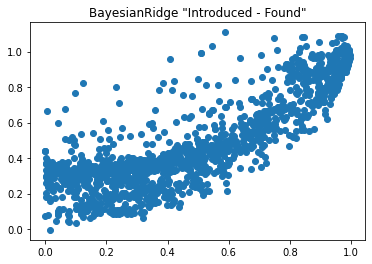

In [ ]:
plt.scatter(y_test,y_pred)
plt.title('BayesianRidge "Introduced - Found"')

##Partial Least Squares

Обучение модели

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)

PLSRegression()

Предсказание

In [ ]:
y_pred = pls.predict(X_test)

Кросс-валидация

In [ ]:
scores = cross_val_score(pls, X, np.ravel(Y), cv=10)
print("Cross-validated scores:", scores)

predictions = cross_val_predict(pls, X, np.ravel(Y), cv=10)

Cross-validated scores: [0.61628842 0.61999805 0.77139889 0.66500608 0.60126924 0.65324013
 0.68728495 0.56245883 0.6919467  0.52021418]


Подсчёт метрик точности модели

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = pls.score(X_test, np.ravel(y_test))

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Accuracy: {r2:.2f}')

Mean absolute error: 0.13
Mean squared error: 0.03
Root mean squared error: 0.16
Accuracy: 0.70


Визуализация качества модели графиком "Введено - найдено"

Text(0.5, 1.0, 'Partial Least Squares "Introduced - Found"')

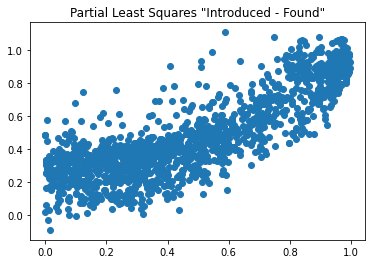

In [ ]:
plt.scatter(y_test,y_pred)
plt.title('Partial Least Squares "Introduced - Found"')